<a href="https://colab.research.google.com/github/Sarvani-5/KneeOA_DL/blob/main/InceptionResnet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Download the dataset from Kaggle
path = kagglehub.dataset_download("tommyngx/digital-knee-xray")
print("Path to dataset files:", path)

# Define destination path in Google Drive
drive_path = '/content/drive/MyDrive/KneeOA'  # Change this to your preferred path

# Copy the dataset to Google Drive
if os.path.exists(drive_path):
    shutil.rmtree(drive_path)  # Remove if already exists
shutil.copytree(path, drive_path)

print(f"Dataset successfully saved to Google Drive at: {drive_path}")

Mounted at /content/drive
Path to dataset files: /kaggle/input/digital-knee-xray
Dataset successfully saved to Google Drive at: /content/drive/MyDrive/KneeOA


In [1]:
from google.colab import drive
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Define class mapping
knee_classes = {'0Normal': 0, '1Doubtful': 1, '2Mild': 2, '3Moderate': 3, '4Severe': 4}
class_names = list(knee_classes.keys())

# Enhanced data loader that combines both datasets
def load_combined_data(exp1_path, exp2_path, image_size=200):
    X, y = [], []

    # Load MedicalExpert-I
    print("Loading MedicalExpert-I...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp1_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    # Load MedicalExpert-II
    print("\nLoading MedicalExpert-II...")
    for class_name, class_idx in knee_classes.items():
        class_path = os.path.join(exp2_path, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Missing directory {class_path}")
            continue

        print(f"Processing {class_name}...", end=' ')
        count = 0
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue

                img = cv2.resize(img, (image_size, image_size))
                # Convert grayscale to RGB by repeating the channel
                img_rgb = cv2.merge([img, img, img])
                X.append(img_rgb)
                y.append(class_idx)
                count += 1
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
        print(f"Loaded {count} samples")

    return np.array(X), np.array(y)

# Paths to your datasets - UPDATE THESE
medical_expert_I_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-I"
medical_expert_II_path = "/content/drive/MyDrive/KneeOA/MedicalExpert-II"

# Load combined data
X, y = load_combined_data(medical_expert_I_path, medical_expert_II_path)

# Check class distribution
print("\nClass distribution in combined dataset:")
for class_name, class_idx in knee_classes.items():
    print(f"{class_name}: {np.sum(y == class_idx)} samples")

# Convert to float32 and preprocess for InceptionResNetV2
X = X.astype('float32')
X = preprocess_input(X)  # Preprocess for InceptionResNetV2
y = to_categorical(y, num_classes=5)

# Split into train and test sets (now combining both datasets)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"\nTraining samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='constant',
    cval=0
)

# Build model using InceptionResNetV2
def build_inception_resnet():
    base_model = InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(200, 200, 3),
        pooling=None
    )

    # Freeze the base model layers first
    base_model.trainable = False

    inputs = Input(shape=(200, 200, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)

    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model, base_model

model, base_model = build_inception_resnet()
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy'),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=1e-6),
    ModelCheckpoint('/content/drive/MyDrive/KneeOA/best_model.keras',
                   monitor='val_accuracy',
                   save_best_only=True,
                   mode='max')
]

# First train with frozen layers
print("\nTraining top layers...")
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=30,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Unfreeze some layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:len(base_model.layers)//2]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("\nFine-tuning model...")
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    epochs=100,
    initial_epoch=history.epoch[-1],
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Combine histories
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_fine.history[key]

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Save final model in .keras format
model.save('/content/drive/MyDrive/KneeOA/knee_oa_inception_resnet.keras')
print("Model saved as knee_oa_inception_resnet.keras")

# Sample predictions
def predict_sample_images(model, X_test, y_test, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices, 1):
        image = X_test[idx]
        true_class = np.argmax(y_test[idx])

        # Make prediction
        pred_probs = model.predict(np.expand_dims(image, axis=0))
        pred_class = np.argmax(pred_probs)

        # Convert image back for display
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0-1

        plt.subplot(1, num_samples, i)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample predictions
print("\nSample predictions on test set:")
predict_sample_images(model, X_test, y_test, num_samples=5)

Loading MedicalExpert-I...
Processing 0Normal... Loaded 514 samples
Processing 1Doubtful... Loaded 477 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Loading MedicalExpert-II...
Processing 0Normal... Loaded 504 samples
Processing 1Doubtful... Loaded 488 samples
Processing 2Mild... Loaded 232 samples
Processing 3Moderate... Loaded 221 samples
Processing 4Severe... Loaded 206 samples

Class distribution in combined dataset:
0Normal: 1018 samples
1Doubtful: 965 samples
2Mild: 464 samples
3Moderate: 442 samples
4Severe: 412 samples

Training samples: 2640
Test samples: 661
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_resnet_v2             │ (None, 4, 4, 1536)     │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_203         │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,732,517 (208.79 MB)

 Trainable params: 395,269 (1.51 MB)

 Non-trainable params: 54,337,248 (207.28 MB)


Training top layers...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 99s 804ms/step - accuracy: 0.2854 - loss: 2.2309 - val_accuracy: 0.3737 - val_loss: 1.4146 - learning_rate: 1.0000e-04
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 367ms/step - accuracy: 0.4230 - loss: 1.6345 - val_accuracy: 0.4992 - val_loss: 1.1918 - learning_rate: 1.0000e-04
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 31s 375ms/step - accuracy: 0.4638 - loss: 1.4997 - val_accuracy: 0.5401 - val_loss: 1.2310 - learning_rate: 1.0000e-04
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 380ms/step - accuracy: 0.4704 - loss: 1.3676 - val_accuracy: 0.5764 - val_loss: 1.0353 - learning_rate: 1.0000e-04
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step - accuracy: 0.4770 - loss: 1.3250 - val_accuracy: 0.5703 - val_loss: 1.1190 - learning_rate: 1.0000e-04
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 32s 382ms/step - accuracy: 0.5402 - loss: 1.2241 - val_accuracy: 0.6157 - val_loss: 0.9736 - learning_rate: 1.0000e-04
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 28s 339ms/step - acc

In [3]:

# Save final model in .keras format
model.save('/content/drive/MyDrive/KneeOA/knee_oa_inception_resnet.keras')
print("Model saved as knee_oa_inception_resnet.keras")

Model saved as knee_oa_inception_resnet.keras


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step

Confusion Matrix:
[[192  12   0   0   0]
 [ 18 168   7   0   0]
 [  1  11  75   5   1]
 [  0   0   3  86   0]
 [  0   2   1   0  79]]


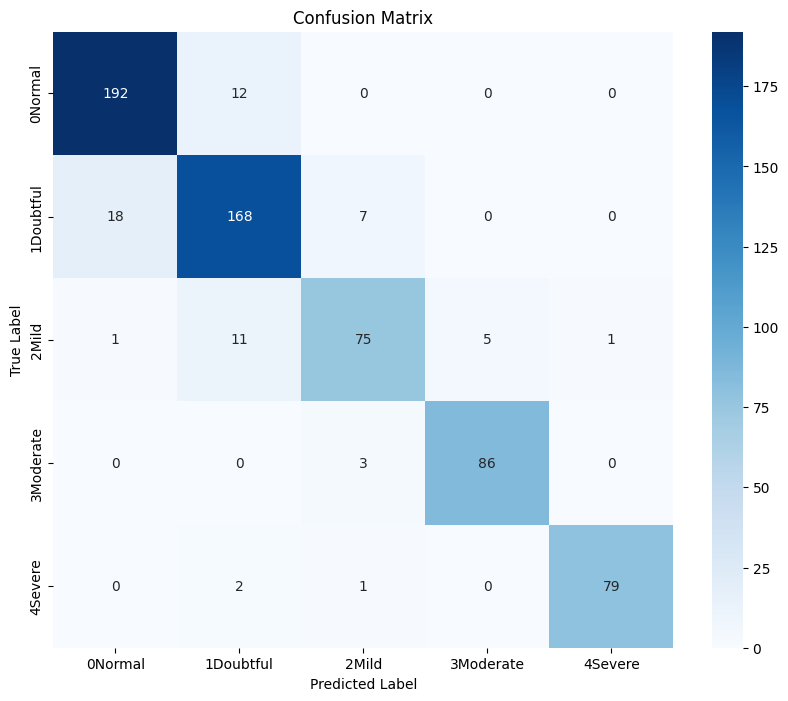


Classification Report:
              precision    recall  f1-score   support

     0Normal       0.91      0.94      0.93       204
   1Doubtful       0.87      0.87      0.87       193
       2Mild       0.87      0.81      0.84        93
   3Moderate       0.95      0.97      0.96        89
     4Severe       0.99      0.96      0.98        82

    accuracy                           0.91       661
   macro avg       0.92      0.91      0.91       661
weighted avg       0.91      0.91      0.91       661



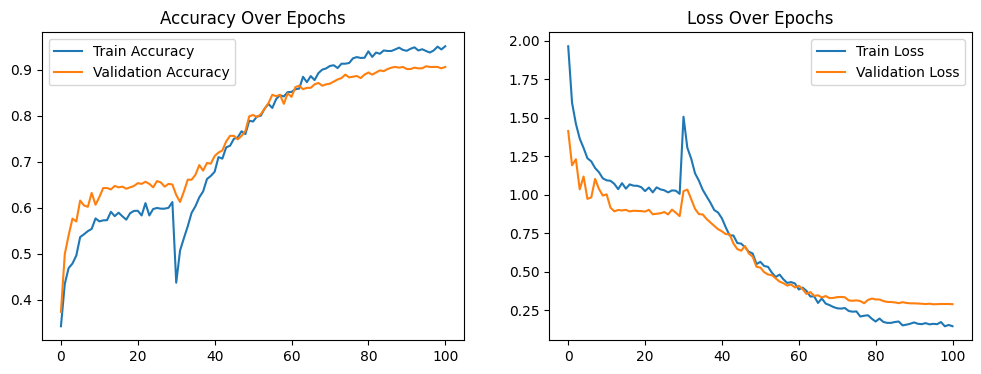

Model saved as knee_oa_inception_resnet.keras

Sample predictions on test set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


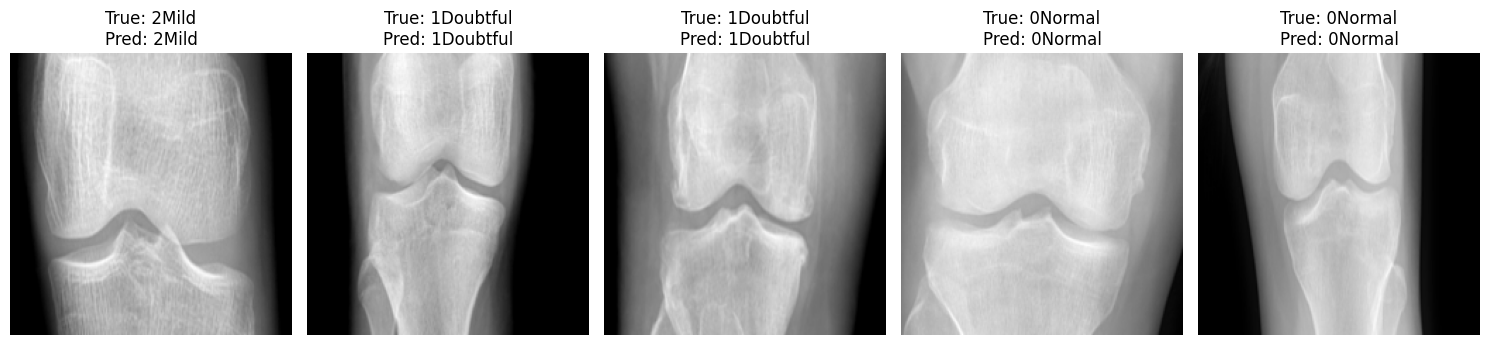

In [5]:
import seaborn as sns
# Combine histories
combined_history = {}
for key in history.history:
    combined_history[key] = history.history[key] + history_fine.history[key]

# Evaluate model
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(combined_history['accuracy'], label='Train Accuracy')
plt.plot(combined_history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(combined_history['loss'], label='Train Loss')
plt.plot(combined_history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Save final model in .keras format
model.save('/content/drive/MyDrive/KneeOA/knee_oa_inception_resnet.keras')
print("Model saved as knee_oa_inception_resnet.keras")

# Sample predictions
def predict_sample_images(model, X_test, y_test, num_samples=5):
    sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(sample_indices, 1):
        image = X_test[idx]
        true_class = np.argmax(y_test[idx])

        # Make prediction
        pred_probs = model.predict(np.expand_dims(image, axis=0))
        pred_class = np.argmax(pred_probs)

        # Convert image back for display
        image = (image - image.min()) / (image.max() - image.min())  # Normalize to 0-1

        plt.subplot(1, num_samples, i)
        plt.imshow(image)
        plt.title(f"True: {class_names[true_class]}\nPred: {class_names[pred_class]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display sample predictions
print("\nSample predictions on test set:")
predict_sample_images(model, X_test, y_test, num_samples=5)